In [1]:
#Consolidating our wave analysis pipeline into functions: 
#v0.1 alpha version, this is the first consolidation of analysis done so far
#Requires the environment packages found in napari-env

In [1]:
#General Import Packages: 
#Plotting
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import seaborn as sns
import trackpy as tp

#Numerics, model implementation, path management, extras: 
import numpy as np
import pandas as pd
from pathlib import Path
import random as rand
from tqdm import tqdm 
from scipy.special import erfc

#Signal Analysis Functions: 
from scipy.signal import savgol_filter
from scipy.signal import peak_widths
from scipy.optimize import curve_fit

In [2]:
#Custom function to read in centroid arrays into dataframe instead of as a string: 
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [3]:
#Defining a basic power law function to fit to our wave relations r^2:
def func_powerlaw(x, a, m):
    return m*x**a

In [4]:
#Importing the relevant data frames is done using the following structure: 

#Set the base path as the root for an analysis set, all sets are arranged where images and analysis outputs are in the following locations: 
base_path = base_path = Path.cwd().parent / 'Data Sets/2023_01_24_LTB4-inhib'
#base_path = Path('/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_LTB4-inhib')

images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

#There are three important dataframes used in analysis, the wave data frame, the ARCOS df, and the tracking df with binnned calcium values:
#The tracking is the most broad, followed by ARCOS and then the wave (most abstracted info):
wave_dataframe_paths = sorted(analysis_output_destination.glob('*_wave_df.csv'), key=lambda x: x.stem.split('_')[0])
arcos_dataframe_paths = sorted(analysis_output_destination.glob('*_ARCOS_df.csv'), key=lambda x: x.stem.split('_')[0])
tracking_dataframe_paths = sorted(analysis_output_destination.glob('*_tracking_binned_df.csv'), key=lambda x:x.stem.split('_')[0])


In [5]:
#If things get to unweildly for using big csv files alone, consider: 
#https://arrow.apache.org/docs/python/feather.html
#https://github.com/apache/arrow

In [6]:
#To consolodate all the wave dataframes in a set, use the following function: 
#INPUT: Sorted list of all wave dataframe csv locations:
#Option to save the DF as a csv in the relevant location is given, default is False
#OUTPUT: A dataframe containing all of the csv wave DFs in the path list

def consolidate_waves(WAVE_DF_PATHS, save_DF = False):
    
    wave_collect = []

    for wave_df_path in tqdm(WAVE_DF_PATHS):
        img_id = int(wave_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        wave_df = pd.read_csv(wave_df_path, converters={"wave_centroid": read_tuple_list}) #Open the wave_DF from step4 analysis
        wave_df = wave_df[wave_df.columns.drop(list(wave_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        track_ids = wave_df['clTrackID'].values #Get the collective track values in the wave
        wave_df['wave_ID'] = [str(img_id) + '-' + str(i) for i in track_ids] #Build a list of unique wave IDs from the image number and clTrack number they belong to
        wave_df['image_ID'] = [img_id for i in range(len(wave_df))]
        wave_collect.append(wave_df)
    
    wave_df_collected = pd.concat(wave_collect, ignore_index=True)
    
    if save_DF:
        wave_df_collected.to_csv(WAVE_DF_PATHS[0].parent / 'combined_wave_DF.csv', index=False)
        
    return wave_df_collected

In [7]:
#To consolodate all the ARCOS dataframes in a set, use the following function: 
#INPUT: Sorted list of all ARCOS dataframe csv locations:
#Option to save the DF as a csv in the relevant location is given, default is False
#OUTPUT: A dataframe containing all of the csv arcos DFs in the path list

def consolidate_arcos(ARCOS_DF_PATHS, save_DF = False):
    
    arcos_collect = []

    for arcos_df_path in tqdm(ARCOS_DF_PATHS):
        img_id = int(arcos_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        arcos_df = pd.read_csv(arcos_df_path) #Open the arcos_DF from step3 analysis
        arcos_df = arcos_df[arcos_df.columns.drop(list(arcos_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        track_ids = arcos_df['clTrackID'].values #Get the collective track values in the wave
        arcos_df['wave_ID'] = [str(img_id) + '-' + str(i) for i in track_ids] #Build a list of unique wave IDs from the image number and clTrack number they belong to
        arcos_df['image_ID'] = [img_id for i in range(len(arcos_df))]
        arcos_collect.append(arcos_df)
    
    arcos_df_collected = pd.concat(arcos_collect, ignore_index=True)
    
    if save_DF:
        arcos_df_collected.to_csv(ARCOS_DF_PATHS[0].parent / 'combined_arcos_DF.csv', index=False)
        
    return arcos_df_collected

In [8]:
#To consolodate all the tracking dataframes in a set, use the following function: 
#INPUT: Sorted list of all tracking dataframe csv locations:
#Option to save the DF as a csv in the relevant location is given, default is False
#OUTPUT: A dataframe containing all of the csv tracking DFs in the path list

def consolidate_tracking(TRACKING_DF_PATHS, save_DF = False):
    
    tracking_collect = []

    for tracking_df_path in tqdm(TRACKING_DF_PATHS):
        img_id = int(tracking_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        tracking_df = pd.read_csv(tracking_df_path) #Open the arcos_DF from step3 analysis
        tracking_df = tracking_df[tracking_df.columns.drop(list(tracking_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        tracking_df['image_ID'] = [img_id for i in range(len(tracking_df))]
        tracking_collect.append(tracking_df)
    
    tracking_df_collected = pd.concat(tracking_collect, ignore_index=True)
    
    if save_DF:
        tracking_df_collected.to_csv(TRACKING_DF_PATHS[0].parent / 'combined_tracking_DF.csv', index=False)
        
    return tracking_df_collected

In [9]:
wave_con_df = consolidate_waves(wave_dataframe_paths)

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 360.65it/s]


In [10]:
wave_con_df['time_real'] = wave_con_df['rel_time'] * 5.0

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

Text(0, 0.5, 'Radius (um)')

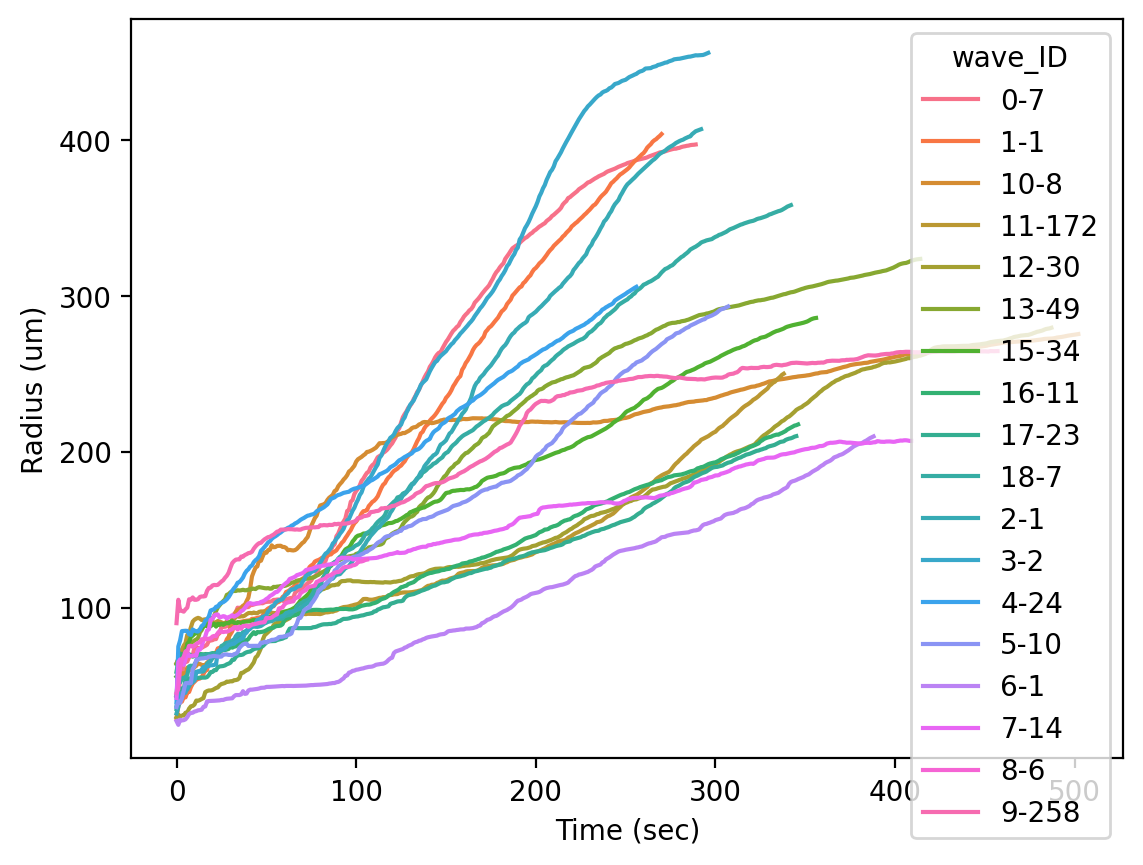

In [11]:
#Next are key wave analysis functions:
#Plotting all the waves in a set
plt.figure(dpi=200)
sns.lineplot(data=wave_con_df, x='rel_time', y='circle_radius', hue='wave_ID')
plt.xlabel('Time (sec)')
plt.ylabel('Radius (um)')

In [16]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5, 'font.family': ['arial'], 'axes.linewidth':2})


/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

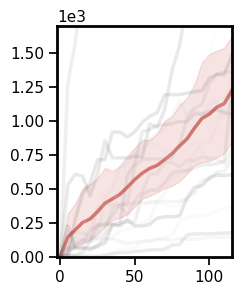

In [43]:
#Here we only care about wave behavior in the first 2 mintutes of the travel time:
#This is to avoid drift from the assay that seems to occur on larger (slower) timescales. 
#This is so we can also fit a power law to this data to see how its R^2 values evolve in time, 
#>1 is superdiffusive
#=1 is diffusive behavior
#<1 is subdiffuisive

#Get values pre-split
wave_initial = wave_con_df
wave_initial = wave_initial[wave_initial['time_real'] < 120]

#Fit to our power law eq defined above where x=time, y=R^2
#Because time will matter for fit, timestep to time is 5sec/frame:
#pars, cov = curve_fit(f=func_powerlaw, xdata=wave_initial.time_real.values, ydata=wave_initial.r_squared.values, p0=[1, 100])

#Note, pars is an array of [a, b,wave_initial['time_real'] = wave_initial['rel_time'] * 5.0 m] where m*x**a

#Interpolate time values to graph alongside data:
#t_interpol = np.linspace(0,wave_initial.time_real.max())

#plot the results with the title showing the fit parameters
plt.figure(figsize=(2.25,3))
sns.lineplot(data=wave_initial,x='time_real', y='r_squared', color='#D27770')
sns.lineplot(data=wave_initial,x='time_real', y='r_squared', hue='wave_ID', palette='Greys', alpha=0.1, legend=False)
plt.xlim(-2,wave_initial.time_real.max())
plt.ylim(-2,1700)
plt.xlabel('')
plt.ylabel('')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('fig2-ltb4-block-early-wave-average-msd.png', dpi=400, bbox_inches='tight')
#plt.savefig('figure-2-ltb4-inhibition.svg')

In [42]:
block_simple_fit = pd.read_csv("diffusion relay compare/fits/BIIL315_simple.csv")

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

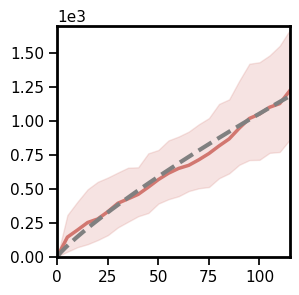

In [45]:
#Waves are split into growing and receeeding by their calcium signal in step4, 
#MAX CALCIUM peak as of 20221013
#This means we can look at wave starts and wave ends seperately by splitting our DF by when the split column is either 0 or 1:

#PRESPLIT IS EARLY WAVE DYNAMICS:

#This is so we can also fit a power law to this data to see how its R^2 values evolve in time, 
#>1 is superdiffusive
#=1 is diffusive behavior
#<1 is subdiffuisive

#Get values pre-split
wave_initial = wave_whitelist_DF
wave_initial = wave_initial[wave_initial['time_real'] < 120]

#Fit to our power law eq defined above where x=time, y=R^2
#Because time will matter for fit, timestep to time is 5sec/frame:
#pars, cov = curve_fit(f=func_powerlaw, xdata=wave_initial.time_real.values, ydata=wave_initial.r_squared.values, p0=[1, 100])

#Note, pars is an array of [a, b,wave_initial['time_real'] = wave_initial['rel_time'] * 5.0 m] where m*x**a

#Interpolate time values to graph alongside data:
#t_interpol = np.linspace(0,wave_initial.time_real.max())

#plot the results with the title showing the fit parameters
plt.figure(figsize=(3,3))
sns.lineplot(data=wave_initial,x='time_real', y='r_squared', color='#D27770')
sns.lineplot(data=block_simple_fit,x='time', y='r_simple', color='grey', linestyle='--', linewidth=3, legend=False)
plt.xlim(0,wave_initial.time_real.max())
plt.ylim(-2,1700)
plt.xlabel('')
plt.ylabel('')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('fig2-biil315-wave-average-fits.png', dpi=400, bbox_inches='tight')
#plt.savefig('figure-2-ltb4-inhibition.svg')

In [46]:
wave_con_df.to_csv('biil315-block_wave_fig2_DF.csv')

In [50]:
wave_fits = []
save_path = Path.cwd() / 'indiv_fits/biil315/'

sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

for wid, wave in wave_initial.groupby('wave_ID'):
    #Fit to our power law eq defined above where x=time, y=R^2
    #Because time will matter for fit, timestep to time is 5sec/frame:
    t_interpol = np.linspace(0,wave.time_real.max())
    pars, cov = curve_fit(f=func_powerlaw, xdata=wave.time_real.values, ydata=wave.r_squared.values, p0=[1, 100])
    wave_fits.append([wid, pars[0], pars[1]])
    #plot the results with the title showing the fit parameters
    
    '''
    plt.figure(figsize=(2.5,2.5))
    ax = sns.lineplot(data=wave,x='time_real', y='r_squared', color = '#D27770')
    ax.tick_params(direction='out', width=2, labelsize=10)
    plt.plot(t_interpol, func_powerlaw(t_interpol, *pars), linestyle='--', linewidth=2, color='black')
    plt.xlim(0,wave.time_real.max())
    plt.xlabel('')
    plt.ylabel('')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    fname = str(wid) + '.png'
    plt.savefig(save_path / fname, bbox_inches='tight', dpi=300)
    plt.close()
    '''
    


/var/folders/jb/q2707w2155s00qd5b8lpx_6m0000gn/T/ipykernel_95923/3599666436.py:3: RuntimeWarning: divide by zero encountered in power
  return m*x**a


In [51]:
wave_fits_DF = pd.DataFrame(np.array(wave_fits, dtype=object), columns=['wid', 'alpha', 'm'])

In [53]:
wave_fits_DF.to_csv('fig2-ltb4-block-individual-fits.csv')

In [61]:
wave_fits_DF.alpha.mean()

1.077332168562458

In [62]:
wave_fits_DF.alpha.std()

0.517728451165994

In [56]:
print('Volunteer N: {}'.format(str(len(wave_initial['volunteer_ID'].unique()))))
print('Wave n: {}'.format(str(len(wave_initial['wave_ID'].unique()))))

Volunteer N: 6
Wave n: 18
